# XCDAT Demo: testing general functions on regridded E3SM data
In this document, E3SM model output is loaded by using [xcdat](https://xcdat.readthedocs.io/en/latest/). 

Demo data used in this document is the time-series of regridded surface temperature (ts) simulated by E3SM, and the model's land fraction. Those data can be found from [E3SM data server](https://web.lcrc.anl.gov/public/e3sm/e3sm_diags_test_data/time-series/E3SM_v1/)

Author: Jiwoo Lee, Jill Zhang (2021. 10)

In [2]:
import os

In [3]:
demo_data_dir = '/Users/zhang40/Documents/ACME_simulations/E3SM_v1'
demo_filename = 'TS_185001_201312.nc'
demo_file = os.path.join(demo_data_dir, demo_filename)

## 1. Open dataset using xcdat

### 1.1 Load dataset into memory

In [4]:
import xcdat

In [59]:
ds = xcdat.open_dataset(demo_file, data_var = 'TS')

In [54]:
ts = ds.TS

<xarray.DataArray 'TS' (time: 1968, lat: 129, lon: 256)>
[64991232 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -88.59 -87.19 -85.78 ... 85.78 87.19 88.59 90.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time     (time) object 1850-02-01 00:00:00 ... 2014-01-01 00:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_methods:   time: mean
    cell_measures:  area: area

### 1.2 Data quick check

#### Check dimensions

In [12]:
ts.shape

(1968, 129, 256)

#### Field quick view -- plot data on the first time step

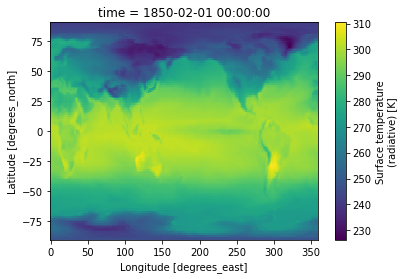

In [13]:
ts.isel(time=0).plot()

# Or, below commends do the same:

# ts[0].plot()
# ts.isel(time=slice(0, 1)).plot()
# ts.sel(time=ds.ts.time[0]).plot()

#### Check date of first time step: Note that monthly E3SM data recode time at the end of each time interval. The first time step is decoded as Feb 1st. 

In [14]:
ts.time[0].values

array(cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

#### Check date of last time step 

In [15]:
ts.time[-1].values

array(cftime.DatetimeNoLeap(2014, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

### 1.3 Subset

#### Original dimensions

In [11]:
ts.shape

(1872, 145, 192)

#### Temporal subset

In [17]:
ts1 = ts.sel(time=slice('1851-01-01', '1851-12-31'))
ts1.shape

(12, 129, 256)

#### Spatial subset

In [19]:
ts2 = ts.sel(lat=slice(20, 50), lon=slice(220, 320))
ts2.shape

(1968, 21, 71)

#### Spatio-tempoal subset

In [21]:
ts3 = ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59'), lat=slice(20, 50), lon=slice(220, 320))
ts3.shape

(12, 21, 71)

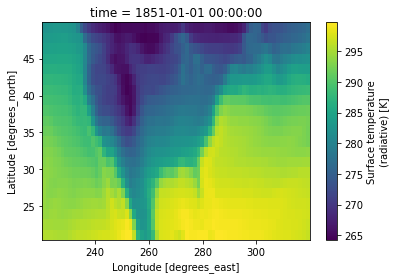

In [24]:
ts3[0].plot()

You can also visualize data on a map using [cartropy](https://scitools.org.uk/cartopy/docs/latest/) as below. Useage example also can be found [here](http://xarray.pydata.org/en/stable/user-guide/plotting.html).

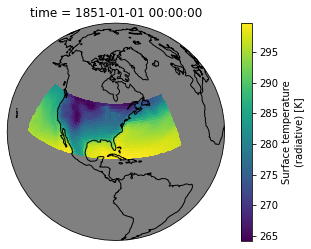

In [25]:
import cartopy.crs as ccrs

p = ts3.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

PMP uses [predefined domains](https://github.com/PCMDI/pcmdi_metrics/blob/master/share/default_regions.py), as well as E3SM_diags [predefined_domains](https://github.com/E3SM-Project/e3sm_diags/blob/master/e3sm_diags/derivations/default_regions.py). Below capability was made to mimic that capability.

In [26]:
def region_subset(d, regions_specs, region=None):
    
    if ((region == None) or 
        (region != None) and (region not in list(regions_specs.keys()))):
        print('Error: region not defined')
    else:    
        if 'domain' in list(regions_specs[region].keys()):
            if 'latitude' in list(regions_specs[region]['domain'].keys()):
                lat0 = regions_specs[region]['domain']['latitude'][0]
                lat1 = regions_specs[region]['domain']['latitude'][1]
                if 'latitude' in (d.coords.dims):
                    d = d.sel(latitude=slice(lat0, lat1))
                elif 'lat' in (d.coords.dims):
                    d = d.sel(lat=slice(lat0, lat1))

            if 'longitude' in list(regions_specs[region]['domain'].keys()):
                lon0 = regions_specs[region]['domain']['longitude'][0]
                lon1 = regions_specs[region]['domain']['longitude'][1]
                if 'longitude' in (d.coords.dims):
                    d = d.sel(longitude=slice(lon0, lon1))
                elif 'lon' in (d.coords.dims):
                    d = d.sel(lon=slice(lon0, lon1))

    return d

In [27]:
regions_specs = {
    'NHEX': {'domain': {'latitude': (30., 90)}},
    'SHEX': {'domain': {'latitude': (-90., 30)}},
    'TROPICS': {'domain': {'latitude': (-30., 30)}},
    'global': {},
    }

In [19]:
ts4 = region_subset(ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59')), regions_specs, 'NHEX')
ts4.shape

(12, 49, 192)

In [20]:
ts4 = region_subset(ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59')), regions_specs, 'TROPICS')
ts4.shape

(12, 49, 192)

In [28]:
ts4 = region_subset(ts.sel(time=slice('1851-01-01 00:00:00', '1851-12-31 23:59:59')), regions_specs, 'global')
ts4.shape

(12, 129, 256)

## 2. Annual Cycle

In [31]:
ts_ann = ts.groupby('time.month').mean('time')

In [32]:
ts_ann.shape

(12, 129, 256)

## 3. Seasonal Mean

In [33]:
ts_seasons = ts.groupby('time.season').mean('time')

In [34]:
ts_seasons.shape

(4, 129, 256)

## 4. Land-sea mask

- Open land fraction of the given model grid and apply land or sea mask to the field of interest, using [`xarray.DataArray.where`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) capbility.
- Relvant example usage also can be found [here](https://geohackweek.github.io/nDarrays/09-masking/).

In [35]:
demo_lsmsk_filename = 'LANDFRAC_185001_201312.nc'
demo_lsmsk_file = os.path.join(demo_data_dir, demo_lsmsk_filename)

In [39]:
ds_lsmsk = xcdat.open_dataset(demo_lsmsk_file, data_var = 'LANDFRAC')
ds_lsmsk

<xarray.Dataset>
Dimensions:    (time: 1968, lat: 129, lon: 256, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.59 -87.19 -85.78 ... 87.19 88.59 90.0
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time       (time) object 1850-02-01 00:00:00 ... 2014-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    LANDFRAC   (time, lat, lon) float32 ...
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
    time_bnds  (time, nbnd) object ...
Attributes: (12/19)
    ne:                        30
    np:                        4
    Conventions:               CF-1.0
    source:                    CAM
    case:                      20180215.DECKv1b_H1.ne30_oEC.edison
    title:                     UNSET
    ...                        ...
    history:                   Tue Aug 28 18:30:58 2018: ncks -t 2 -O --no_tm...
    NCO:                       netCDF Operators version 4.7.6 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /p/cscratch/acme/data/map_ne30np4_to_fv129x256...
    input_file:                /p/user_pub/e3sm/baldwin32/deck/v1_DECK_histor...
    xcdat_infer:               LANDFRAC

In [42]:
sftlf = ds_lsmsk.LANDFRAC

### 4.1 Land

In [43]:
ts_land = ts.where(sftlf!=0.)

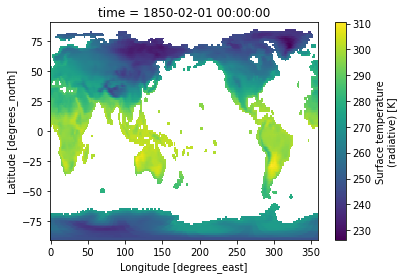

In [44]:
ts_land.isel(time=0).plot()

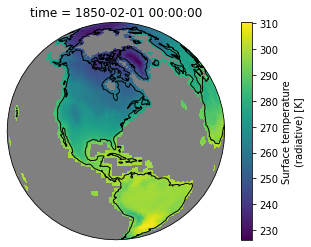

In [46]:
p = ts_land.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

### 4.2 Ocean

In [47]:
ts_sea = ts.where(sftlf==0.)

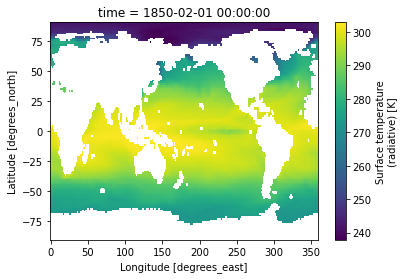

In [48]:
ts_sea.isel(time=0).plot()

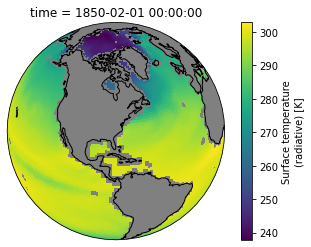

In [50]:
p = ts_sea.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()